In [ ]:
!pip install langchain langgraph langsmith langchain-groq langchain_community langchain-tavily chromadb

In [ ]:
!pip install better-profanity

In [ ]:
import os
import uuid
import re
from typing import TypedDict, Annotated
from langchain_core.messages import AIMessage, HumanMessage
from langchain_tavily import TavilySearch
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph.message import add_messages
import chromadb
from chromadb.utils import embedding_functions
from chromadb.config import Settings
from langchain_groq import ChatGroq
from langgraph.prebuilt import ToolNode, tools_condition
from better_profanity import profanity

llm = ChatGroq(model="openai/gpt-oss-120b", groq_api_key=groq_api_key)

profanity.load_censor_words()

class State(TypedDict):
    messages: Annotated[list, add_messages]
    conversation_id: str

tool = TavilySearch(max_results=2, tavily_api_key=tavily_api_key)

tools = [tool]
llm_with_tools = llm.bind_tools(tools)

chroma_client = chromadb.PersistentClient(
    path="./chroma_db",
    settings=Settings(anonymized_telemetry=False)
)
embedding_function = embedding_functions.DefaultEmbeddingFunction()
collection = chroma_client.get_or_create_collection(
    name="conversation_history_1",
    embedding_function=embedding_function
)

def store_in_chroma(state: State):
    """Store conversation messages in ChromaDB"""
    conversation_id = state.get("conversation_id", str(uuid.uuid4()))
    messages = state["messages"]

    message_texts = [f"{msg.type}: {msg.content}" for msg in messages]

    collection.add(
        documents=message_texts,
        metadatas=[{"conversation_id": conversation_id, "index": i} for i in range(len(messages))],
        ids=[f"{conversation_id}_{i}" for i in range(len(messages))]
    )
    return conversation_id

def retrieve_context(state: State) -> str:
    """Retrieve relevant context from ChromaDB"""
    conversation_id = state.get("conversation_id", "")
    last_message_content = state["messages"][-1].content if state["messages"] else ""

    if not conversation_id or not last_message_content:
        return ""

    results = collection.query(
        query_texts=[last_message_content],
        n_results=3,
        where={"conversation_id": conversation_id}
    )
    context = "\n".join(doc for doc in results["documents"][0] if doc)
    return context

def privacy_filter(state: State):
    """Redacts personally identifiable information (PII) from the user's message."""
    messages = state["messages"]
    last_message = messages[-1]

    if isinstance(last_message, HumanMessage):
        content = last_message.content

        # Redact common PII formats
        redacted_content = content
        # Redact phone numbers
        redacted_content = re.sub(r'\b(?:\+?8801[1-9]\d{8}|01[1-9]\d{8})\b', '[PHONE_NUMBER]', redacted_content) 
        # Redact email addresses
        redacted_content = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', '[EMAIL_ADDRESS]', redacted_content)
        # Redact credit card
        redacted_content = re.sub(r'\b(?:\d[ -]*?){13,16}\b', '[CREDIT_CARD]', redacted_content)
        # Redact simple name pattern
        redacted_content = re.sub(r'my name is (\w+)', 'my name is [REDACTED_NAME]', redacted_content, flags=re.IGNORECASE)

        # Update the message in the state with the redacted content
        messages[-1] = HumanMessage(content=redacted_content, name=last_message.name)

    return {"messages": messages}


# Custom word lists
bad_words = ['sex', 'fuck', 'shit', 'bitch', 'asshole', 'dick', 'pussy', 'porn', 'slut', 'damn']
obfuscated_bad_words = {
    'sex': r's[e3]x',
    'fuck': r'f[u@*]ck?',
    'shit': r's[h#*]i[t+]',
    'bitch': r'b[i1!][t+]?ch',
    'asshole': r'a[s5$]{2}h[o0]le',
    'pussy': r'p[u*]ss[yie]',
    'porn': r'p[o0]rn',
    'slut': r's[l1!][u*]t',
}

def content_moderation_filter(state: State):
    messages = state["messages"]
    last_message = messages[-1]

    if isinstance(last_message, HumanMessage):
        content = last_message.content

        # Better profanity
        censored = profanity.censor(content)
        censored = re.sub(r'\*+', '[REDACTED]', censored)

        # Exact match
        for word in bad_words:
            censored = re.sub(r'\b' + re.escape(word) + r'\b', '[REDACTED]', censored, flags=re.IGNORECASE)

        # Obfuscated words
        for word, pattern in obfuscated_bad_words.items():
            censored = re.sub(pattern, '[REDACTED]', censored, flags=re.IGNORECASE)

        # Update the message in the state with the redacted content
        messages[-1] = HumanMessage(content=censored, name=last_message.name)

    return {"messages": messages, "conversation_id": state["conversation_id"]}


def tool_calling_llm(state: State):
    context = retrieve_context(state)

    if context:
        prompt = f"Context from previous conversation:\n{context}\n\nCurrent messages:\n{state['messages']}"
    else:
        prompt = state["messages"]

    conversation_id = store_in_chroma(state)

    state["conversation_id"] = conversation_id

    return {
        "messages": [llm_with_tools.invoke(prompt)],
        "conversation_id": conversation_id
    }

memory = MemorySaver()

builder = StateGraph(State)

builder.add_node("privacy_filter", privacy_filter)
builder.add_node("content_moderation_filter", content_moderation_filter)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "privacy_filter")
builder.add_edge("privacy_filter", "content_moderation_filter")
builder.add_edge("content_moderation_filter", "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition
)
builder.add_edge("tools", "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)

graph = builder.compile(checkpointer=memory)

config={"configurable":{"thread_id":"5"}}
response = graph.invoke({
     "messages": [HumanMessage(content="My email is sony@liveai.com and my name is Sony and my number is 01712345678. That person is a piece of shit and fucking idiot! By the way, I want to know about Bangladesh")],
    "conversation_id": str(uuid.uuid4())
}, config)

print(response)

{'messages': [HumanMessage(content='My email is [EMAIL_ADDRESS] and my name is [REDACTED_NAME] and my number is [PHONE_NUMBER]. That person is a piece of [REDACTED] and [REDACTED] idiot! By the way, I want to know about Bangladesh', additional_kwargs={}, response_metadata={}, id='f4fd5ef2-9659-4dca-ae11-9bc9464eff0d'), AIMessage(content='Sure! Here’s an overview of Bangladesh:\n\n### Geography & Demographics\n- **Location:** South‑Asia, bordered by India on the west, north, and east, Myanmar to the southeast, and the Bay of Bengal to the south.  \n- **Area:** About 148,460\u202fkm² (57,230\u202fmi²), making it roughly the size of the U.S. state of Iowa.  \n- **Population:** Over 170\u202fmillion people (2023 estimate), making it the world’s eighth‑most‑populous country.  \n- **Capital & Largest City:** Dhaka.  \n- **Official Language:** Bengali (Bangla).  \n- **Religion:** Predominantly Islam (≈\u202f90\u202f%); Hinduism is the largest minority (≈\u202f8\u202f%).  \n\n### History Highl

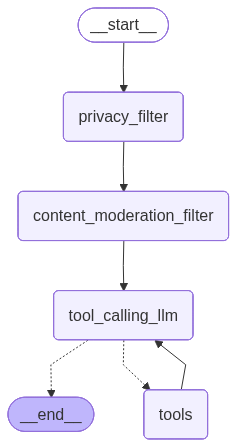

In [64]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
import gradio as gr
from langchain_core.messages import HumanMessage

# Function to call the LangGraph AI agent
def process_message(user_input):
    try:
        response = graph.invoke({
            "messages": [HumanMessage(content=user_input)],
            "conversation_id": str(uuid.uuid4())  # Optional: track thread if needed
        }, config={"configurable": {"thread_id": "5"}})

        # Extract the last AI message
        ai_messages = response.get("messages", [])
        last_response = ai_messages[-1].content if ai_messages else "No response generated."
        return last_response

    except Exception as e:
        return f"Error: {str(e)}"

# Create a chat interface
with gr.Blocks() as demo:
    gr.Markdown("## AI Agent")
    gr.Markdown("Type your questions below. Type 'exit' or 'quit' to end the conversation (console version).")

    chatbot = gr.Chatbot(height=400)
    msg_box = gr.Textbox(label="Your Question", placeholder="Ask me a question...")

    def respond(message, history):
        if message.strip().lower() in ["exit", "quit"]:
            return history + [[message, "Exiting..."]], ""
        answer = process_message(message)
        return history + [[message, answer]], ""

    msg_box.submit(respond, [msg_box, chatbot], [chatbot, msg_box])

# Run Gradio app
if __name__ == "__main__":
    demo.launch(server_name="0.0.0.0", server_port=7860)  # Change port no if needed 